# Modeling

In the preprocessing/training notebook the accuracy came out to be very unsatisfactory for the baseloine results. Overfitting is a big concern. I will be testing 2 additional models over and above Logistic Regression and Random Forest Classifier. **XGBoost** and **LGBM**, paired with 2 oversampling methods **SMOTE** and **ADYSYN**.

Changes from previous notebook:
> Splitting minority class evenly 20/20 and concatenating to 80/20 majority class

> Conducting dummy encoding after train test split on X_train and X_test

> Removing Standard Scaler

In [1]:
import numpy as np
import pandas as pd
import pickle
import datetime

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings(action = 'ignore')
import gc

In [2]:
with open('lending_club_modeling_pick.pkl', 'rb') as pickle_file:
    df = pickle.load(pickle_file)

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
#pd.reset_option('display.float_format')
pd.set_option('display.max_columns', None)

In [4]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,TARGET
0,3600.00000,3600.00000,3600.00000,36,13.99000,123.03000,C,C4,10,MORTGAGE,55000.00000,Not Verified,16770.00000,n,debt_consolidation,PA,5.91000,0.00000,12265.00000,675.00000,679.00000,1.00000,30.00000,72.31284,7.00000,0.00000,2765.00000,29.70000,13.00000,w,0.00000,0.00000,4421.72392,4421.72000,3600.00000,821.72000,0.00000,0.00000,0.00000,17897.00000,122.67000,18017.00000,17956.00000,564.00000,560.00000,0.00000,30.00000,Individual,0.00000,722.00000,144904.00000,2.00000,2.00000,0.00000,1.00000,21.00000,4981.00000,36.00000,3.00000,3.00000,722.00000,34.00000,9300.00000,3.00000,1.00000,4.00000,4.00000,20701.00000,1506.00000,37.20000,0.00000,0.00000,148.00000,128.00000,3.00000,3.00000,1.00000,4.00000,69.00000,4.00000,69.00000,2.00000,2.00000,4.00000,2.00000,5.00000,3.00000,4.00000,9.00000,4.00000,7.00000,0.00000,0.00000,0.00000,3.00000,76.90000,0.00000,0.00000,0.00000,178050.00000,7746.00000,2400.00000,13734.00000,N,Cash,N,0
1,24700.00000,24700.00000,24700.00000,36,11.99000,820.28000,C,C1,10,MORTGAGE,65000.00000,Not Verified,16770.00000,n,small_business,SD,16.06000,1.00000,10926.00000,715.00000,719.00000,4.00000,6.00000,72.31284,22.00000,0.00000,21470.00000,19.20000,38.00000,w,0.00000,0.00000,25679.66000,25679.66000,24700.00000,979.66000,0.00000,0.00000,0.00000,16953.00000,926.35000,18017.00000,17956.00000,699.00000,695.00000,0.00000,44.16422,Individual,0.00000,0.00000,204396.00000,1.00000,1.00000,0.00000,1.00000,19.00000,18005.00000,73.00000,2.00000,3.00000,6472.00000,29.00000,111800.00000,0.00000,0.00000,6.00000,4.00000,9733.00000,57830.00000,27.10000,0.00000,0.00000,113.00000,192.00000,2.00000,2.00000,4.00000,2.00000,37.00000,0.00000,6.00000,0.00000,5.00000,5.00000,13.00000,17.00000,6.00000,20.00000,27.00000,5.00000,22.00000,0.00000,0.00000,0.00000,2.00000,97.40000,7.70000,0.00000,0.00000,314017.00000,39475.00000,79300.00000,24667.00000,N,Cash,N,0
2,20000.00000,20000.00000,20000.00000,60,10.78000,432.66000,B,B4,10,MORTGAGE,63000.00000,Not Verified,16770.00000,n,home_improvement,IL,10.78000,0.00000,11170.00000,695.00000,699.00000,0.00000,34.54092,72.31284,6.00000,0.00000,7869.00000,56.20000,18.00000,w,0.00000,0.00000,22705.92429,22705.92000,20000.00000,2705.92000,0.00000,0.00000,0.00000,17318.00000,15813.30000,18017.00000,17956.00000,704.00000,700.00000,0.00000,44.16422,Joint App,0.00000,0.00000,189699.00000,0.00000,1.00000,0.00000,4.00000,19.00000,10827.00000,73.00000,0.00

In [5]:
df.shape

(2257221, 107)

In [6]:
df[df['TARGET'] == 1].iloc[20:, :].shape

(20, 107)

# Conducting Train Test Split

In [7]:
def dummy_encoding(df):
    
    df = pd.get_dummies(df)
    
    return df

In [8]:
def preprocess_inputs(df):
    df = df.copy()
    
    #Sampling 500k from target 0
    df_t0_sample = df[df['TARGET'] == 0].sample(n = 500000, random_state = 1)
    #df_t1 = df[df['TARGET'] == 1]
    #df = pd.concat([df_t0_sample, df_t1], ignore_index = True)
    
    #split into x and y arrays
    y = df_t0_sample['TARGET']
    X = df_t0_sample.drop('TARGET', axis = 1)
    
    #Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1, stratify = y)
    
    df_t1 = df[df['TARGET'] == 1].iloc[:20, :]
    df_t2 = df[df['TARGET'] == 1].iloc[20:, :]
    print(df_t1.head())
    
    y1 = df_t1['TARGET'] #ytrain
    X1 = df_t1.drop('TARGET', axis = 1) #xtrain
    y2 = df_t2['TARGET'] #ytest
    X2 = df_t2.drop('TARGET', axis = 1) #xtest
    
    #Concat 
    X_train = pd.concat([X_train, X1], ignore_index = True)
    X_test = pd.concat([X_test, X2], ignore_index = True)
    y_train = y_train.append(y1, ignore_index = True)
    y_test = y_test.append(y2, ignore_index = True)
    
    #Dummies
    X_train = dummy_encoding(X_train)
    X_test = dummy_encoding(X_test)
    
    #Scale X
#     sc = StandardScaler()
#     sc.fit(X_train)
#     X_train = sc.transform(X_train)
#     X_test = sc.transform(X_test)    
    
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(df)

         loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
33636  35000.00000  35000.00000      35000.00000    60  20.99000    946.68000   
427430 30000.00000  30000.00000      30000.00000    36  17.47000   1076.62000   
487674 25000.00000  25000.00000      25000.00000    60  21.45000    682.68000   
492122 10000.00000  10000.00000      10000.00000    60  19.03000    259.58000   
521688  3000.00000   3000.00000       3000.00000    36  19.03000    110.02000   

       grade sub_grade  emp_length home_ownership   annual_inc  \
33636      E        E5          10            OWN 105000.00000   
427430     D        D1          10            OWN  70000.00000   
487674     D        D5           8           RENT  36000.00000   
492122     D        D3           1           RENT  30000.00000   
521688     D        D3           4           RENT  35000.00000   

       verification_status     issue_d pymnt_plan             purpose  \
33636             Verified 16770.00000     

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400020, 222), (400020,), (100020, 222), (100020,))

## Oversampling with SMOTE

SMOTE uses synthetic data to increase the number of samples in the minority class. It finds the n-nearest neighbors in TARGET == 1 and draws a line between each neighbors and creates random points along the line.

In [12]:
sm = SMOTE(random_state=12, sampling_strategy = 'minority')
X_train_r, y_train_r = sm.fit_resample(X_train, y_train)

In [13]:
X_train_r.shape, y_train_r.shape

((800000, 222), (800000,))

### Logistic Regression SMOTE

In [14]:
clf = LogisticRegression(C = 0.0001, random_state = 21)

clf.fit(X_train_r, y_train_r) 

LogisticRegression(C=0.0001, random_state=21)

In [15]:
y_predict_test = clf.predict(X_test)
print("\n")
print("[Test] Accuracy score (y_predict_test, y_test):",accuracy_score(y_predict_test, y_test))

y_predict_training = clf.predict(X_train_r)
print("\n")
print("[Training] Accuracy score: (y_train_r, y_predict_training)",accuracy_score(y_train_r, y_predict_training))



[Test] Accuracy score (y_predict_test, y_test): 0.7940611877624475


[Training] Accuracy score: (y_train_r, y_predict_training) 0.8523875


In [16]:
print("[Training Classification Report]")
print(classification_report(y_train_r, y_predict_training))

print("[Test Classification Report]")
print(classification_report(y_test, y_predict_test))

[Training Classification Report]
              precision    recall  f1-score   support

           0       0.90      0.79      0.84    400000
           1       0.81      0.91      0.86    400000

    accuracy                           0.85    800000
   macro avg       0.86      0.85      0.85    800000
weighted avg       0.86      0.85      0.85    800000

[Test Classification Report]
              precision    recall  f1-score   support

           0       1.00      0.79      0.89    100000
           1       0.00      0.60      0.00        20

    accuracy                           0.79    100020
   macro avg       0.50      0.70      0.44    100020
weighted avg       1.00      0.79      0.89    100020



In [17]:
print("Confusion Matrix Train: \n {}\n".format(confusion_matrix(y_train_r, y_predict_training)))   
print("Confusion Matrix Test: \n {}\n".format(confusion_matrix(y_test, y_predict_test)))   

Confusion Matrix Train: 
 [[316834  83166]
 [ 34924 365076]]

Confusion Matrix Test: 
 [[79410 20590]
 [    8    12]]



In [42]:
from sklearn.model_selection import cross_val_score

cv_scores_test= cross_val_score(clf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(clf,X_train_r,y_train_r,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.7519375 0.786325  0.544025  0.65545   0.810375 ]
Mean cross validation test score: 0.7096225
Mean cross validation train score: 0.9115413053437502
Standard deviation in cv test scores: 0.09816525938436674


Recall score seems to have increased significantly but precision is still off.

### Random Forest SMOTE

In [43]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=21)
clf_rf.fit(X_train_r, y_train_r)

RandomForestClassifier(random_state=21)

In [44]:
y_predict_test_rf = clf_rf.predict(X_test)
print("\n")
print("[Test] Accuracy score (y_predict_test, y_test):",accuracy_score(y_predict_test_rf, y_test))

y_predict_training_rf = clf_rf.predict(X_train_r)
print("\n")
print("[Training] Accuracy score: (y_train_r, y_predict_training)",accuracy_score(y_train_r, y_predict_training_rf))



[Test] Accuracy score (y_predict_test, y_test): 0.9998000399920016


[Training] Accuracy score: (y_train_r, y_predict_training) 1.0


In [45]:
print("[Test Classification Report]")
print(classification_report(y_test, y_predict_test_rf))

[Test Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100000
           1       0.00      0.00      0.00        20

    accuracy                           1.00    100020
   macro avg       0.50      0.50      0.50    100020
weighted avg       1.00      1.00      1.00    100020



In [39]:
print("Confusion Matrix Train: \n {}\n".format(confusion_matrix(y_train_r, y_predict_training_rf)))   
print("Confusion Matrix Test: \n {}\n".format(confusion_matrix(y_test, y_predict_test_rf)))   

Confusion Matrix Train: 
 [[400000      0]
 [     1 399999]]

Confusion Matrix Test: 
 [[100000      0]
 [    20      0]]



In [63]:
cv_scores_test= cross_val_score(clf_rf, X_test, y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(clf_rf, X_train_r, y_train_r,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_test_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' + str(cv_scores_rf_test))
print ('Mean cross validation train score: ' + str(cv_scores_rf_train))
print ('Standard deviation in cv test scores: ' + str(cv_scores_std_test_rf))

[0.490025   0.61818125 0.61804375 0.87186875 0.865175  ]
Mean cross validation test score: 0.69265875
Mean cross validation train score: 0.99999999378125
Standard deviation in cv test scores: 0.1510316612398705


### XGBoost SMOTE

In [21]:
from xgboost import XGBClassifier

In [22]:
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train_r, y_train_r)

[15:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
y_predict_test_xgb = clf_xgb.predict(X_test)
print("\n")
print("[Test] Accuracy score (y_predict_test, y_test):",accuracy_score(y_predict_test_xgb, y_test))

y_predict_training_xgb = clf_xgb.predict(X_train_r)
print("\n")
print("[Training] Accuracy score: (y_train_r, y_predict_training)",accuracy_score(y_train_r, y_predict_training_xgb))



[Test] Accuracy score (y_predict_test, y_test): 0.9998000399920016


[Training] Accuracy score: (y_train_r, y_predict_training) 1.0


In [24]:
print("[Training Classification Report]")
print(classification_report(y_train_r, y_predict_training_xgb))

print("[Test Classification Report]")
print(classification_report(y_test, y_predict_test_xgb))

[Training Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400000
           1       1.00      1.00      1.00    400000

    accuracy                           1.00    800000
   macro avg       1.00      1.00      1.00    800000
weighted avg       1.00      1.00      1.00    800000

[Test Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100000
           1       0.00      0.00      0.00        20

    accuracy                           1.00    100020
   macro avg       0.50      0.50      0.50    100020
weighted avg       1.00      1.00      1.00    100020



In [46]:
print("Confusion Matrix Train: \n {}\n".format(confusion_matrix(y_train_r, y_predict_training_xgb)))   
print("Confusion Matrix Test: \n {}\n".format(confusion_matrix(y_test, y_predict_test_xgb)))   

Confusion Matrix Train: 
 [[400000      0]
 [     0 400000]]

Confusion Matrix Test: 
 [[100000      0]
 [    20      0]]



In [65]:
cv_scores_test= cross_val_score(clf_xgb, X_test, y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(clf_xgb, X_train_r, y_train_r,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_xgb_test= cv_scores_test.mean()
cv_scores_xgb_train= cv_scores_train.mean()
cv_scores_std_test_xgb= cv_scores_test.std()
print ('Mean cross validation test score: ' + str(cv_scores_xgb_test))
print ('Mean cross validation train score: ' + str(cv_scores_xgb_train))
print ('Standard deviation in cv test scores: ' + str(cv_scores_std_test_xgb))

[13:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:29:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### LightGBM SMOTE

In [25]:
from lightgbm import LGBMClassifier

In [26]:
clf_lgbm = LGBMClassifier()
clf_lgbm.fit(X_train_r, y_train_r)

LGBMClassifier()

In [27]:
y_predict_test_lgbm = clf_lgbm.predict(X_test)
print("\n")
print("[Test] Accuracy score (y_predict_test, y_test):",accuracy_score(y_predict_test_lgbm, y_test))

y_predict_training_lgbm = clf_lgbm.predict(X_train_r)
print("\n")
print("[Training] Accuracy score: (y_train_r, y_predict_training)",accuracy_score(y_train_r, y_predict_training_lgbm))



[Test] Accuracy score (y_predict_test, y_test): 0.9997900419916017


[Training] Accuracy score: (y_train_r, y_predict_training) 1.0


In [28]:
print("[Training Classification Report]")
print(classification_report(y_train_r, y_predict_training_lgbm))

print("[Test Classification Report]")
print(classification_report(y_test, y_predict_test_lgbm))

[Training Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400000
           1       1.00      1.00      1.00    400000

    accuracy                           1.00    800000
   macro avg       1.00      1.00      1.00    800000
weighted avg       1.00      1.00      1.00    800000

[Test Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100000
           1       0.00      0.00      0.00        20

    accuracy                           1.00    100020
   macro avg       0.50      0.50      0.50    100020
weighted avg       1.00      1.00      1.00    100020



In [47]:
print("Confusion Matrix Train: \n {}\n".format(confusion_matrix(y_train_r, y_predict_training_lgbm)))   
print("Confusion Matrix Test: \n {}\n".format(confusion_matrix(y_test, y_predict_test_lgbm)))   

Confusion Matrix Train: 
 [[400000      0]
 [     0 400000]]

Confusion Matrix Test: 
 [[99999     1]
 [   20     0]]



In [66]:
cv_scores_test= cross_val_score(clf_lgbm, X_test, y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(clf_lgbm, X_train_r, y_train_r,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lgbm_test= cv_scores_test.mean()
cv_scores_lgbm_train= cv_scores_train.mean()
cv_scores_std_test_lgbm= cv_scores_test.std()
print ('Mean cross validation test score: ' + str(cv_scores_lgbm_test))
print ('Mean cross validation train score: ' + str(cv_scores_lgbm_train))
print ('Standard deviation in cv test scores: ' + str(cv_scores_std_test_lgbm))

[0.450525   0.44323125 0.2506     0.6044625  0.4995    ]
Mean cross validation test score: 0.4496637499999999
Mean cross validation train score: 0.999998042890625
Standard deviation in cv test scores: 0.11499113025577236


## Oversampling with ADASYN

ADASYN is similar to SMOTE but adds additional variance i.e. generates synthetic points but not directly along the line.

In [29]:
from imblearn.over_sampling import ADASYN 

In [30]:
rsm = ADASYN(random_state=13, sampling_strategy = 'minority')
X_train_rr, y_train_rr = rsm.fit_resample(X_train, y_train)

In [31]:
X_train_rr.shape, y_train_rr.shape

((800000, 222), (800000,))

### Logistic Regression ADASYN

In [32]:
clf2 = LogisticRegression(C = 0.0001, random_state = 22)

clf2.fit(X_train_rr, y_train_rr) 

LogisticRegression(C=0.0001, random_state=22)

In [33]:
y_predict_test_alr = clf2.predict(X_test)
print("\n")
print("[Test] Accuracy score (y_predict_test_alr, y_test):",accuracy_score(y_predict_test_alr, y_test))

y_predict_training_alr = clf2.predict(X_train_rr)
print("\n")
print("[Training] Accuracy score: (y_train_rr, y_predict_training_alr)",accuracy_score(y_train_rr, y_predict_training_alr))



[Test] Accuracy score (y_predict_test_alr, y_test): 0.7934113177364527


[Training] Accuracy score: (y_train_rr, y_predict_training_alr) 0.85052625


In [34]:
print("[Training Classification Report]")
print(classification_report(y_train_rr, y_predict_training_alr))

print("[Test Classification Report]")
print(classification_report(y_test, y_predict_test_alr))

[Training Classification Report]
              precision    recall  f1-score   support

           0       0.90      0.79      0.84    400000
           1       0.81      0.91      0.86    400000

    accuracy                           0.85    800000
   macro avg       0.86      0.85      0.85    800000
weighted avg       0.86      0.85      0.85    800000

[Test Classification Report]
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    100000
           1       0.00      0.60      0.00        20

    accuracy                           0.79    100020
   macro avg       0.50      0.70      0.44    100020
weighted avg       1.00      0.79      0.88    100020



In [49]:
print("Confusion Matrix Train: \n {}\n".format(confusion_matrix(y_train_r, y_predict_training_alr)))   
print("Confusion Matrix Test: \n {}\n".format(confusion_matrix(y_test, y_predict_test_alr)))   

Confusion Matrix Train: 
 [[316579  83421]
 [ 36158 363842]]

Confusion Matrix Test: 
 [[79345 20655]
 [    8    12]]



### Random Forest ADASYN

In [35]:
clf_rf2 = RandomForestClassifier(n_estimators=40, random_state=22)
clf_rf2.fit(X_train_rr, y_train_rr)

RandomForestClassifier(n_estimators=40, random_state=22)

In [36]:
y_predict_test_rf2 = clf_rf2.predict(X_test)
print("\n")
print("[Test] Accuracy score (y_predict_test, y_test):",accuracy_score(y_predict_test_rf2, y_test))

y_predict_training_rf2 = clf_rf2.predict(X_train_rr)
print("\n")
print("[Training] Accuracy score: (y_train_r, y_predict_training)",accuracy_score(y_train_rr, y_predict_training_rf2))



[Test] Accuracy score (y_predict_test, y_test): 0.9998000399920016


[Training] Accuracy score: (y_train_r, y_predict_training) 0.99999875


In [37]:
print("[Test Classification Report]")
print(classification_report(y_test, y_predict_test_rf2))

[Test Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100000
           1       0.00      0.00      0.00        20

    accuracy                           1.00    100020
   macro avg       0.50      0.50      0.50    100020
weighted avg       1.00      1.00      1.00    100020



In [50]:
print("Confusion Matrix Train: \n {}\n".format(confusion_matrix(y_train_r, y_predict_training_rf2)))   
print("Confusion Matrix Test: \n {}\n".format(confusion_matrix(y_test, y_predict_test_rf2)))   

Confusion Matrix Train: 
 [[400000      0]
 [     1 399999]]

Confusion Matrix Test: 
 [[100000      0]
 [    20      0]]



### XGBoost ADASYN

In [51]:
clf_xgb2 = XGBClassifier()
clf_xgb2.fit(X_train_rr, y_train_rr)

[15:04:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
y_predict_test_xgb2 = clf_xgb2.predict(X_test)
print("\n")
print("[Test] Accuracy score (y_predict_test, y_test):",accuracy_score(y_predict_test_xgb2, y_test))

y_predict_training_xgb2 = clf_xgb2.predict(X_train_rr)
print("\n")
print("[Training] Accuracy score: (y_train_r, y_predict_training)",accuracy_score(y_train_rr, y_predict_training_xgb2))



[Test] Accuracy score (y_predict_test, y_test): 0.9998000399920016


[Training] Accuracy score: (y_train_r, y_predict_training) 1.0


In [53]:
print("[Training Classification Report]")
print(classification_report(y_train_rr, y_predict_training_xgb2))

print("[Test Classification Report]")
print(classification_report(y_test, y_predict_test_xgb2))

[Training Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400000
           1       1.00      1.00      1.00    400000

    accuracy                           1.00    800000
   macro avg       1.00      1.00      1.00    800000
weighted avg       1.00      1.00      1.00    800000

[Test Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100000
           1       0.00      0.00      0.00        20

    accuracy                           1.00    100020
   macro avg       0.50      0.50      0.50    100020
weighted avg       1.00      1.00      1.00    100020



In [55]:
print("Confusion Matrix Train: \n {}\n".format(confusion_matrix(y_train_r, y_predict_training_xgb2)))   
print("Confusion Matrix Test: \n {}\n".format(confusion_matrix(y_test, y_predict_test_xgb2)))   

Confusion Matrix Train: 
 [[400000      0]
 [     0 400000]]

Confusion Matrix Test: 
 [[100000      0]
 [    20      0]]



In [62]:
from sklearn.metrics import precision_recall_fscore_support

### LightGBM ADASYN

In [56]:
clf_lgbm2 = LGBMClassifier()
clf_lgbm2.fit(X_train_rr, y_train_rr)

LGBMClassifier()

In [57]:
y_predict_test_lgbm2 = clf_lgbm.predict(X_test)
print("\n")
print("[Test] Accuracy score (y_predict_test, y_test):",accuracy_score(y_predict_test_lgbm2, y_test))

y_predict_training_lgbm2 = clf_lgbm.predict(X_train_rr)
print("\n")
print("[Training] Accuracy score: (y_train_r, y_predict_training)",accuracy_score(y_train_rr, y_predict_training_lgbm2))



[Test] Accuracy score (y_predict_test, y_test): 0.9997900419916017


[Training] Accuracy score: (y_train_r, y_predict_training) 1.0


In [58]:
print("[Training Classification Report]")
print(classification_report(y_train_rr, y_predict_training_lgbm2))

print("[Test Classification Report]")
print(classification_report(y_test, y_predict_test_lgbm2))

[Training Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400000
           1       1.00      1.00      1.00    400000

    accuracy                           1.00    800000
   macro avg       1.00      1.00      1.00    800000
weighted avg       1.00      1.00      1.00    800000

[Test Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100000
           1       0.00      0.00      0.00        20

    accuracy                           1.00    100020
   macro avg       0.50      0.50      0.50    100020
weighted avg       1.00      1.00      1.00    100020



In [60]:
print("Confusion Matrix Train: \n {}\n".format(confusion_matrix(y_train_r, y_predict_training_lgbm2)))   
print("Confusion Matrix Test: \n {}\n".format(confusion_matrix(y_test, y_predict_test_lgbm2)))   

Confusion Matrix Train: 
 [[400000      0]
 [     0 400000]]

Confusion Matrix Test: 
 [[99999     1]
 [   20     0]]



# SMOTE Model Evaulation

> Models Built (Resampling Technique + Classification Algorithm)

> Performance Metrics for minority class from the classification
report (including "support")

> Performance Metrics for majority class from the classification
report (Precision, Recall, F-1, Support)

In [115]:
smotemetrics = pd.read_csv('C:/Users/user/Downloads/Capstone 2 Performance Metrics SMOTE - Sheet1.csv')

In [116]:
display(smotemetrics)

,Model,Accuracy,Precision,Recall,F1,Support
0,lr_train_0,0.98790,1.00000,0.98000,0.99000,400000
1,lr_train_1,0.98790,0.98000,1.00000,0.99000,400000
2,lr_test_0,0.97520,1.00000,0.98000,0.99000,100000
3,lr_test_1,0.97520,0.00000,0.62000,0.00000,8
4,rf_test_0,0.99990,1.00000,1.00000,1.00000,100000
5,rf_test_1,0.99990,0.00000,0.00000,0.00000,8
6,xgb_train_0,1.00000,1.00000,1.00000,1.00000,400000
7,xgb_train_1,1.00000,1.00000,1.00000,1.00000,400000
8,xgb_test_0,1.00000,1.00000,1.00000,1.00000,100000
9,xgb_test_1,0.00000,0.00000,0.00000,0.00000,8


In [69]:
myLabels = ['Logistic Regression', 'Random Forest','XGB', 'LGBM']
score_test= [  cv_scores_lr_test,cv_scores_rf_test,cv_scores_xgb_test,cv_scores_lgbm_test]
score_train= [  cv_scores_lr_train,cv_scores_rf_train,cv_scores_xgb_train,cv_scores_lgbm_train]
Accuracy_score = [accuracy_score(y_predict_test, y_test),accuracy_score(y_predict_test_rf, y_test),accuracy_score(y_predict_test_xgb, y_test),accuracy_score(y_predict_test_lgbm, y_test)]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
print(score_tab_acc)

score_tab

             Algorithm  Model accuracy score
0  Logistic Regression               0.79406
1        Random Forest               0.99980
2                  XGB               0.99980
3                 LGBM               0.99979


,Algorithm,ROC-AUC train score,ROC-AUC test score
0,Logistic Regression,0.91154,0.70962
1,Random Forest,1.00000,0.69266
2,XGB,1.00000,0.92427
3,LGBM,1.00000,0.44966


# ADASYN Model Evaluation

In [117]:
adasynmetrics = pd.read_csv('C:/Users/user/Downloads/Capstone 2 Performance Metrics SMOTE_ADASYN - Sheet2.csv')

In [118]:
display(adasynmetrics)

,Model,Accuracy,Precision,Recall,F1,Support
0,lr_train_0,0.98790,1.00000,0.98000,0.99000,400000
1,lr_train_1,0.98790,0.98000,1.00000,0.99000,400000
2,lr_test_0,0.97520,1.00000,0.98000,0.99000,100000
3,lr_test_1,0.97520,0.00000,0.62000,0.00000,8
4,rf_test_0,0.99990,1.00000,1.00000,1.00000,100000
5,rf_test_1,0.99990,0.00000,0.00000,0.00000,8
6,xgb_train_0,1.00000,1.00000,1.00000,1.00000,400000
7,xgb_train_1,1.00000,1.00000,1.00000,1.00000,400000
8,xgb_test_0,0.99990,1.00000,1.00000,1.00000,100000
9,xgb_test_1,0.99990,0.00000,0.00000,0.00000,8


# Gridsearch CV with Logistic Regression

In [71]:
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_r,y_train_r)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 100.0, 'penalty': 'l2'}
accuracy : 0.8526724999999999


In [72]:
logreg2=LogisticRegression(C=1,penalty="l2")
logreg2.fit(X_train_r,y_train_r)
print("score",logreg2.score(X_test,y_test))

score 0.7917816436712658


In [144]:
y_predict_test_logreg2 = logreg2.predict(X_test)
print("\n")
print("[Test] Accuracy score (y_predict_test, y_test):",accuracy_score(y_predict_test_logreg2, y_test))

y_predict_training_logreg2 = logreg2.predict(X_train_r)
print("\n")
print("[Training] Accuracy score: (y_train_r, y_predict_training)",accuracy_score(y_train_r, y_predict_training_logreg2))



[Test] Accuracy score (y_predict_test, y_test): 0.7917816436712658


[Training] Accuracy score: (y_train_r, y_predict_training) 0.859065


In [145]:
print("Confusion Matrix Train: \n {}\n".format(confusion_matrix(y_train_r, y_predict_training_logreg2)))   
print("Confusion Matrix Test: \n {}\n".format(confusion_matrix(y_test, y_predict_test_logreg2)))   

Confusion Matrix Train: 
 [[315962  84038]
 [ 28710 371290]]

Confusion Matrix Test: 
 [[79185 20815]
 [   11     9]]



Feature: 0, Score: -0.00025
Feature: 1, Score: -0.00024
Feature: 2, Score: -0.00022
Feature: 3, Score: -0.00001
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00005
Feature: 6, Score: 0.00000
Feature: 7, Score: -0.00002
Feature: 8, Score: 0.00005
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00016
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: 0.00001
Feature: 16, Score: -0.00001
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: -0.00024
Feature: 20, Score: -0.00001
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00033
Feature: 23, Score: 0.00033
Feature: 24, Score: 0.00021
Feature: 25, Score: 0.00023
Feature: 26, Score: -0.00009
Feature: 27, Score: 0.00031
Feature: 28, Score: 0.00005
Feature: 29, Score: -0.00006
Feature: 30, Score: -0.00001
Feature: 31, Score: 0.00015
Feature: 32, Score: -0.00038
Feature: 33, Score: -0.00016
Feature: 34, Score: -0.00000
Feature: 35, 

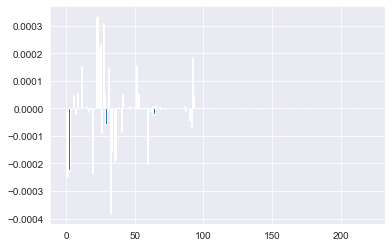

In [77]:
importance = logreg2.coef_[0]
# summarizing feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# LightGBM Hyperparameter Optimisation

In [93]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [94]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [95]:
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [149]:
gs.fit(X_train_r, y_train_r, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid's auc: 0.985761
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid's auc: 0.983958
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid's auc: 0.984689
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid's auc: 0.985715
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid's auc: 0.986218
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid's auc: 0.987228
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid's auc: 0.992246
Training until validation scores don't improve for 30 rounds
Early stopping,

In [96]:
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

In [97]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())

clf_sw.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, subsample=0.855)

In [98]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

In [100]:
gs_sample_weight.fit(X_train_r, y_train_r, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid's auc: 0.966499
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid's auc: 0.977294
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid's auc: 0.966332
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid's auc: 0.962666
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid's auc: 0.957689
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid's auc: 0.950429
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid's auc: 0.94931
Training until validation scores don't improve for 30 rounds
Early stopping, best iter

In [103]:
clf_final = lgb.LGBMClassifier(**clf.get_params())

clf_final.set_params(**opt_parameters)

clf_final.fit(X_train_r, y_train_r, **fit_params)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid's auc: 0.979931


LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, subsample=0.855)

In [113]:
y_predict_test_final = clf_final.predict(X_test)
print("\n")
print("[Test] Accuracy score (y_predict_test, y_test):",accuracy_score(y_predict_test_final, y_test))

y_predict_training_final = clf_final.predict(X_train_r)
print("\n")
print("[Training] Accuracy score: (y_train_r, y_predict_training)",accuracy_score(y_train_r, y_predict_training_final))



[Test] Accuracy score (y_predict_test, y_test): 0.9909518096380724


[Training] Accuracy score: (y_train_r, y_predict_training) 0.99556625


In [114]:
print("Confusion Matrix Train: \n {}\n".format(confusion_matrix(y_train_r, y_predict_training_final)))   
print("Confusion Matrix Test: \n {}\n".format(confusion_matrix(y_test, y_predict_test_final)))   

Confusion Matrix Train: 
 [[396461   3539]
 [     8 399992]]

Confusion Matrix Test: 
 [[99113   887]
 [   18     2]]



<AxesSubplot:>

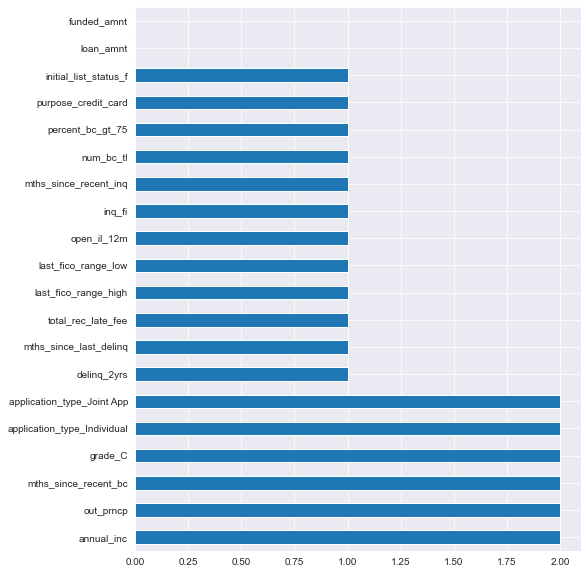

In [112]:
feat_imp = pd.Series(clf_final.feature_importances_, index=X_train_r.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

In [122]:
probabilities = clf_final.predict_proba(X_test)

In [148]:
probabilities

array([[0.59438926, 0.40561074],
       [0.59427656, 0.40572344],
       [0.59434642, 0.40565358],
       ...,
       [0.50484076, 0.49515924],
       [0.50452621, 0.49547379],
       [0.59417964, 0.40582036]])

# Conclusion

For this classification problem we have used 4 Classification algorithms:
- Logistic Regression
- Random Forest
- XGB
- LGBM

combined with with 2 resampling methods:

- SMOTE
- ADASYN

This was a heavily imbalanced dataset and we ran into some major overfitting problems from the get go. Most of the models performed very poorly and initially, the primary goal was to get the model to predict at least 1 outcome. I ended up using a combination of undersampling and oversampling where I took a sample of 500 thousand and evaulated each model based on the confusion matrix and accuracy. 

Next we hyperparameter tuned LGBM and Logistic Regression with grid search CV. Viewing the confusion matrix of LGBM in the context of a buisness, the outcomes were significantly better with only 887 False Negatives compared to the orignal 20590 from Logistic Regression.

The final outcomes are stored in the array **probabilities** where annual income, grade, remaining outstanding principle, months since recent balance, and application type had the highest feature importance. 